<a href="https://colab.research.google.com/github/chandirakumar/Text_Summarization/blob/main/MyThesis_Abstract_Text_Summarization_for_Online_News.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Abstractive Text Summarization for Online News**

### **Step 1: Install and setup libraries**

In [1]:
!pip install datasets rouge_score contractions==0.0.48 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 14.3 MB/s eta 0:00:00


In [2]:
!pip install transformers[torch] -q
!pip install accelerate -U tensorflow -U -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 112.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 87.9 MB/s eta 0:00:00


In [3]:
from transformers import pipeline, set_seed
from rouge_score import rouge_scorer
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq
from datasets import load_dataset, load_from_disk, load_metric, load_metric
from tqdm import tqdm
import numpy as np
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize

from contractions import contractions_dict
import re
from matplotlib import pyplot as plt
from transformers import BertTokenizer, BertForMaskedLM, BertModel, BartForConditionalGeneration, BartTokenizer

import nltk
nltk.download('brown')
from nltk.corpus import brown

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


In [25]:
cnn_dataset = load_dataset("cnn_dailymail", "3.0.0")

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [26]:
# prompt: remove 'id' feature from the dataset 'cnn_dataset'
cnn_dataset = cnn_dataset.remove_columns(["id"])

In [27]:
cnn_dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights'],
        num_rows: 11490
    })
})

In [31]:
cnn_dataset = cnn_dataset.filter(lambda example: len(example['article'].split()) < 1100)

Filter:   0%|          | 0/278849 [00:00<?, ? examples/s]

Filter:   0%|          | 0/12989 [00:00<?, ? examples/s]

Filter:   0%|          | 0/11140 [00:00<?, ? examples/s]

In [32]:
cnn_dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights'],
        num_rows: 251611
    })
    validation: Dataset({
        features: ['article', 'highlights'],
        num_rows: 11703
    })
    test: Dataset({
        features: ['article', 'highlights'],
        num_rows: 9983
    })
})

In [33]:
for key, value in list(contractions_dict.items())[:10]:
    print(f'{key} == {value}')

I'm == I am
I'm'a == I am about to
I'm'o == I am going to
I've == I have
I'll == I will
I'll've == I will have
I'd == I would
I'd've == I would have
Whatcha == What are you
amn't == am not


In [34]:
def expand_contractions(text, contraction_map=contractions_dict):
    # Using regex for getting all contracted words
    contractions_keys = '|'.join(contraction_map.keys())
    contractions_pattern = re.compile(f'({contractions_keys})', flags=re.DOTALL)

    def expand_match(contraction):
        # Getting entire matched sub-string
        match = contraction.group(0)
        expanded_contraction = contraction_map.get(match)
        if not expand_contractions:
            print(match)
            return match
        return expanded_contraction
    type(text)
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return  expanded_text

#expand_contractions("y'all can't expand contractions i'd think")

In [35]:
def apply_contractions(dic):
    dic= dic.map(lambda x: {'article': expand_contractions(x['article'])})
    dic= dic.map(lambda x: {'highlights': expand_contractions(x['highlights'])})
    return dic

### Before removing all the punctuations from the article, highlight text, lets sort some of the punctuation replacement.

In [36]:
import string
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


words like, attthempting , ththem, rthemain instead of remain are found in across many article text. Wo we should take of it.

In [37]:
#non_vocab = set()
def vocab_fix_for_th(article):
    fixed = []
    #txt = re.sub('[%s]' % re.escape(string.punctuation), '' , article)
    for txt in article.split(' '):
        if not txt in corpus_vocabs and txt.replace('th', '') in corpus_vocabs:
            txt = txt.replace('th', '')
        fixed.append(txt)
    return ' '.join(fixed)
#vocab_fix_for_th(article)

### Out Of Vocabulary words (OOV)

In [ ]:
# oov_words = list(set(non_vocab))

# len(oov_words)
# #326154

# non_vocab_df = pd.DataFrame({'oov_words': non_vocab})

# #non_vocab_df['Counts'] = non_vocab_df.groupby('oov_words').transform('count')
# z = non_vocab_df['oov_words'].value_counts()

# z1 = z.to_dict() #converts to dictionary

# non_vocab_df['Count_Column'] = non_vocab_df['oov_words'].map(z1)
# non_vocab_df[:10]

In [38]:
special_symbols = string.punctuation
special_symbols = special_symbols.replace('.', '')
special_symbols = special_symbols.replace('-', '')

In [39]:
def clean_text(dic):
    # Converting to lowercase
    res = dic
    res = res.lower()

    # Removing punctuations
    res = ' '.join(['website' if x.find('http') > 0 else x for x in res.split()])
    # Removing the published and updated stamp with date and year
    res = re.sub('published:.*?\d{4} . .*?\d{4} .?', '', res)
    #print('test1', res)
    # Removing the published stamp with date and year
    #res = re.sub('PUBLISHED:.*?\d{4} .', '', res)
    # Removing flower brackets with its content
    res = re.sub(r'{.*?}', '', res)
    res = re.sub(r'\(.*?\)', '', res)
    #print('test2', res)
    # Removing the unknown text '\\a0'
    res = re.sub("\\xa0" , " ", res)
    #print('test3', res)
    # Removing unnecessary characters from text
    res = re.sub(r' (\w+)( \1)+', r' \1', res, flags=re.IGNORECASE)
    res = re.sub(r'\s+', ' ', res)
    res = re.sub("(\\t)", ' ', str(res))
    res = re.sub("(\\r)", ' ', str(res))
    #res = re.sub("(\\n)", ' ', str(res))
    # Remove numeric with text
    #print('test4', res)
    #res = re.sub(r' ([a-z]\.[a-z])\. ', r' \1 ', res)
    #res = re.sub('[0-9(\.|:)?]+', '', res)
    # Change the time to some logic text
    res = re.sub(':', ' ', res)
    #res = re.sub('[0-9:]+ PM', ' after noon ', res)
    res = re.sub(r':', ' ', res)
    res = re.sub("(mailto:)", ' ', res)
    #print('test5', res)
    #res = ' '.join([x.replace('.com', ' website') if ('@' not in x) and ('http' not in x) and ('.com' in x) else x for x in res.split()])
    res = re.sub(r'https?:\/\/.*[\r\n]*', '', res, flags=re.MULTILINE)
    res = re.sub(r'\<a href', ' ', res)
    res = re.sub(r' .\n', '. ', res)
    res = re.sub(r' \. ', ' ', res)
    #print('test6', res)
    res = res.replace(' u ', ' you ')
    res = re.sub(' u(\.)?k(\.) ', ' united kingdom ', res)
    res = re.sub(' u(\.)?s ', ' united states ', res)
    res = re.sub(' u(\.)?n ', ' united nation ', res)
    # Removing the comma inbetween the numeric ex: 169,00 => 16900
    res = re.sub(r'(?<=\d),(?=\d)', '' , res)
    # Removing the whitespace in between the numeric text ex: 169 00 => 16900
    res = re.sub(r'(?<=\d)\s(?=\d)', '' , res)
    # Removing $ sign with dollars text
    res = re.sub(r' \$?(\s)?([0-9]+[\.]?[0-9]?)(\s)?(million|bilion)?', r' \2 \4', res)
    res = re.sub(r"\$(\d+) " , r"\1 dollars ", res)
    # Removing £ sign with pound text
    res = ' '.join([x.replace('£', '') + ' pounds' if x.find('£')>=0 else x for x in res.split()])
    # Removing the empty space in between 'per cent'
    res = res.replace("per cent", "percent")
    # Removing the long text without any space that are more than 20
    res = re.sub(r'\S{20,}', "", res)

    # Removing - (minus) sign with negative text
    #res = re.sub(r' –', 'negative ',res) - the numbers will be removed so this wont make any sense.
    # Removing & (ampersand) sign with and text
    res = re.sub(r'&', 'and ',res)
    # Removing front slash
    #res = re.sub(r'\(.*?\)', '', res)

    # Removing special symbols
    res = re.sub(r'& ', "and ", res)
    res = re.sub(r'% ', 'percent ', res)
    res = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', res)
    #res = re.sub('[%s]' % re.escape(special_symbols), '' , res)

    # Fixing the vocabulary issue with 'th' removal
    res = vocab_fix_for_th(res)

    #print('last test', res)
    #dic['article'] = res
    return res

In [40]:
# prompt: use nltk stopwords for english
corpus_vocabs = set(brown.words())
stop_words = stopwords.words('english')

def remove_stopwords(dic):
    art = dic['article']
    art_res = ' '.join([x for x in art.split() if x not in stop_words])
    dic['article'] = art_res
    highlight = dic['highlights']
    highlight_res = ' '.join([x for x in highlight.split() if x not in stop_words])
    dic['highlights'] = highlight_res
    return dic

# train_cleaned_dic_no_stop_words = sm_cleaned_dic.map(remove_stopwords)
# test_cleaned_dic_no_stop_words = sm_cleaned_test_dic.map(remove_stopwords)

In [41]:
def apply_clean_text(dic, remove_stopwords=False):
    dic = dic.map(lambda x: {'article': clean_text(x['article'])})
    dic = dic.map(lambda x: {'highlights': clean_text(x['highlights'])})
    if remove_stopwords:
        dic = remove_stopwords(dic)
    return dic

In [9]:
def plot_word_length(dic, dataset_label='train', desc='Before cleaning the text'):
    word_count_article = [len(x.split()) for x in dic['article']]
    plt.figure(figsize=(5,4))
    plt.plot(sorted(word_count_article))
    plt.title(f'Word Counts for article from {dataset_label} Dataset - {desc}')

    word_count_highlights = [len(x.split()) for x in dic['highlights']]
    plt.figure(figsize=(5,4))
    plt.plot(sorted(word_count_highlights))
    plt.title(f'Word Counts for highlights from {dataset_label} Dataset - {desc}')
    plt.show()

In [ ]:
plot_word_length(cnn_dataset['train'], 'train', 'Before pre-processing text')

In [ ]:
plot_word_length(cnn_dataset['test'], 'test', 'Before pre-processing text')

In [42]:
train_cnn_dataset =  apply_contractions(cnn_dataset['train'])
train_cnn_dataset = apply_clean_text(train_cnn_dataset)

test_cnn_dataset = apply_contractions(cnn_dataset['test'])
test_cnn_dataset = apply_clean_text(test_cnn_dataset)

validation_cnn_dataset = apply_contractions(cnn_dataset['validation'])
validation_cnn_dataset = apply_clean_text(validation_cnn_dataset)

Map:   0%|          | 0/251611 [00:00<?, ? examples/s]

Map:   0%|          | 0/251611 [00:00<?, ? examples/s]

Map:   0%|          | 0/251611 [00:00<?, ? examples/s]

Map:   0%|          | 0/251611 [00:00<?, ? examples/s]

Map:   0%|          | 0/9983 [00:00<?, ? examples/s]

Map:   0%|          | 0/9983 [00:00<?, ? examples/s]

Map:   0%|          | 0/9983 [00:00<?, ? examples/s]

Map:   0%|          | 0/9983 [00:00<?, ? examples/s]

Map:   0%|          | 0/11703 [00:00<?, ? examples/s]

Map:   0%|          | 0/11703 [00:00<?, ? examples/s]

Map:   0%|          | 0/11703 [00:00<?, ? examples/s]

Map:   0%|          | 0/11703 [00:00<?, ? examples/s]

In [43]:
train_cnn_dataset = train_cnn_dataset.filter(lambda x: len(x['article'].split()) < 1024 )
test_cnn_dataset = test_cnn_dataset.filter(lambda x: len(x['article'].split()) < 1024 )
validation_cnn_dataset = validation_cnn_dataset.filter(lambda x: len(x['article'].split()) < 1024 )

Filter:   0%|          | 0/251611 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9983 [00:00<?, ? examples/s]

Filter:   0%|          | 0/11703 [00:00<?, ? examples/s]

In [44]:
print('Train: ', len(train_cnn_dataset), ", Test: ", len(test_cnn_dataset), ", Validation: ", len(validation_cnn_dataset))

Train:  242793 , Test:  9606 , Validation:  11258


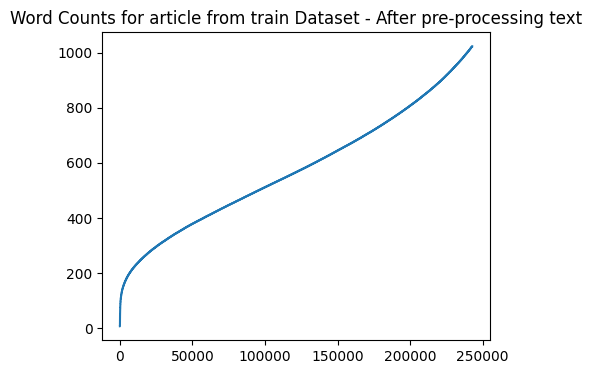

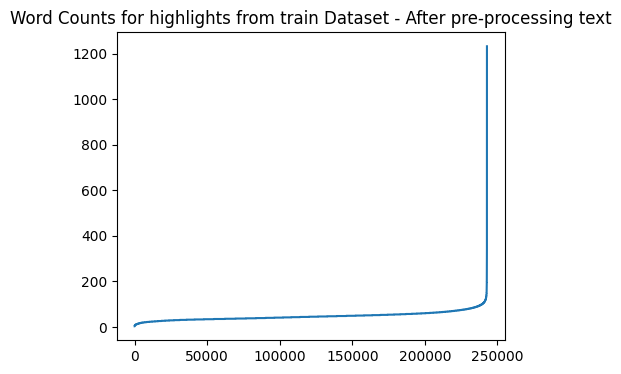

In [49]:
plot_word_length(train_cnn_dataset, 'train', 'After pre-processing text')

In [ ]:
plot_word_length(test_cnn_dataset, 'test', 'After pre-processing text')

In [50]:
# To customize colours of wordcloud texts
from random import randint
from wordcloud import WordCloud
import seaborn as sns
from PIL import Image

def wc_blue_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(214, 67%%, %d%%)" % randint(60, 100)

# plot wordcloud
def plot_wordcloud(text, color_func):
    #wc_stopwords = get_wc_stopwords()
    wc = WordCloud(stopwords=stop_words, width=1200, height=600, random_state=0).generate(text)

    f, axs = plt.subplots(figsize=(15, 10))
    with sns.axes_style("ticks"):
        sns.despine(offset=10, trim=True)
        plt.imshow(wc.recolor(color_func=color_func, random_state=0), interpolation="bilinear")
        plt.xlabel('WordCloud')

In [51]:
text = [' '.join(x.split()) for x in train_cnn_dataset['article']]
text = ' '.join(text)

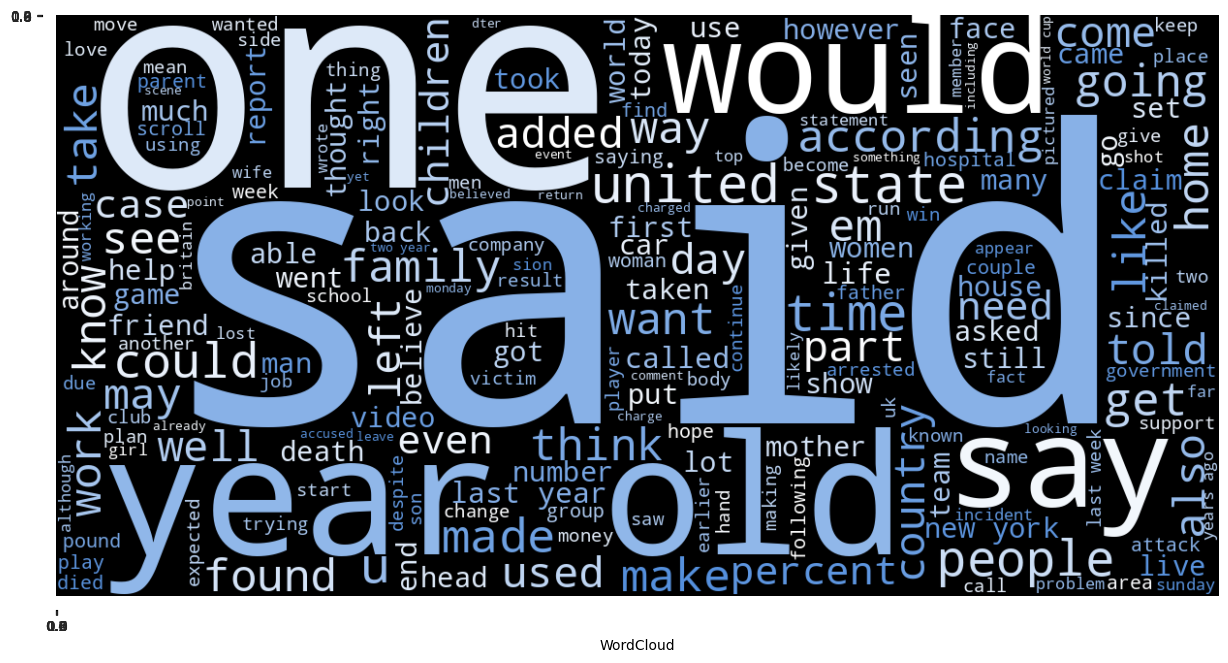

In [52]:
plot_wordcloud(text, wc_blue_color_func)

### Changing the dictionary dataset to dataframe

In [ ]:
# cnn_train_df_sm = pd.DataFrame.from_dict(train_cleaned_dic_no_stop_words)
# cnn_test_df_sm = pd.DataFrame.from_dict(test_cleaned_dic_no_stop_words)

In [53]:
train_cnn_dataset.save_to_disk('/content/drive/MyDrive/Colab Notebooks/ATS/BART_CNN_LARGE/cnn_train_clean_1k')
test_cnn_dataset.save_to_disk('/content/drive/MyDrive/Colab Notebooks/ATS/BART_CNN_LARGE/cnn_test_clean_1k')
validation_cnn_dataset.save_to_disk('/content/drive/MyDrive/Colab Notebooks/ATS/BART_CNN_LARGE/cnn_validation_clean_1k')

Saving the dataset (0/2 shards):   0%|          | 0/242793 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/9606 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/11258 [00:00<?, ? examples/s]

In [ ]:
sm_cleaned_dic.save_to_disk('/content/drive/MyDrive/Colab Notebooks/ATS/BART_CNN_LARGE/cnn_train_clean_sm_2')
sm_cleaned_test_dic.save_to_disk('/content/drive/MyDrive/Colab Notebooks/ATS/BART_CNN_LARGE/cnn_test_clean_sm_2')


Saving the dataset (0/1 shards):   0%|          | 0/23629 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/23629 [00:00<?, ? examples/s]

In [ ]:
cnn_sm_train = load_from_disk('/content/drive/MyDrive/Colab Notebooks/ATS/BART_CNN_LARGE/cnn_train_clean_sm_2')
cnn_sm_test = load_from_disk('/content/drive/MyDrive/Colab Notebooks/ATS/BART_CNN_LARGE/cnn_test_clean_sm_2')

In [4]:
cnn_train = load_from_disk('/content/drive/MyDrive/Colab Notebooks/ATS/BART_CNN_LARGE/cnn_train_clean_1k')
cnn_test = load_from_disk('/content/drive/MyDrive/Colab Notebooks/ATS/BART_CNN_LARGE/cnn_test_clean_1k')
cnn_validation = load_from_disk('/content/drive/MyDrive/Colab Notebooks/ATS/BART_CNN_LARGE/cnn_validation_clean_1k')

In [5]:
cnn_train = cnn_train.map(lambda x: {'article': re.sub(r'(^\s?)', '', x['article'])})
cnn_test = cnn_test.map(lambda x: {'article': re.sub(r'(^\s?)', '', x['article'])})
cnn_validation = cnn_validation.map(lambda x: {'article': re.sub(r'(^\s?)', '', x['article'])})

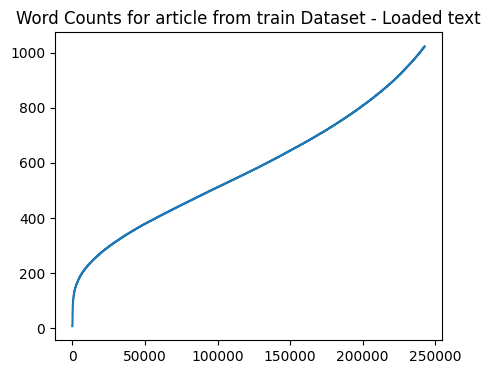

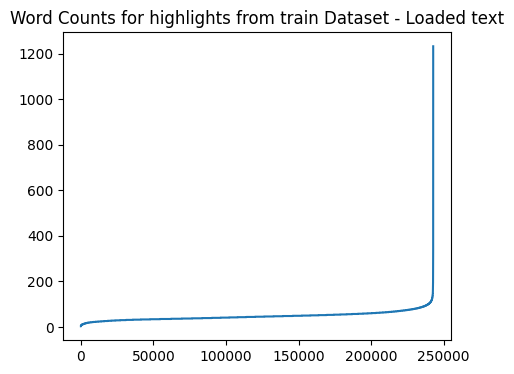

In [55]:
plot_word_length(cnn_train, 'train', "Loaded text")

In [5]:
cnn_train_sm = cnn_train.filter(lambda x: len(x['article'].split()) <= 900 and len(x['highlights'].split()) <= 128)

In [6]:
cnn_test_sm = cnn_test.filter(lambda x: len(x['article'].split()) <= 900 and len(x['highlights'].split()) <= 128)

In [7]:
cnn_validation_sm = cnn_validation.filter(lambda x: len(x['article'].split()) <= 900 and len(x['highlights'].split()) <= 128)

In [ ]:
cnn_train_sm.save_to_disk('/content/drive/MyDrive/Colab Notebooks/ATS/BART_CNN_LARGE/cnn_train_clean_full')
cnn_test_sm.save_to_disk('/content/drive/MyDrive/Colab Notebooks/ATS/BART_CNN_LARGE/cnn_test_clean_full')
cnn_validation_sm.save_to_disk('/content/drive/MyDrive/Colab Notebooks/ATS/BART_CNN_LARGE/cnn_validation_clean_full')

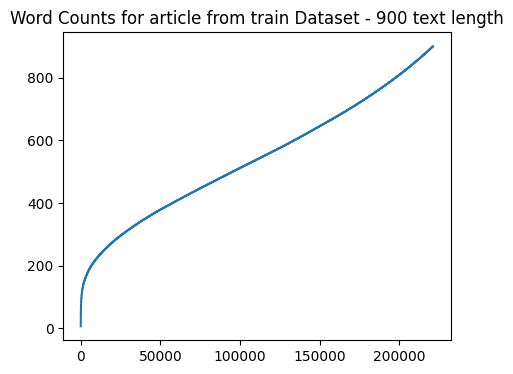

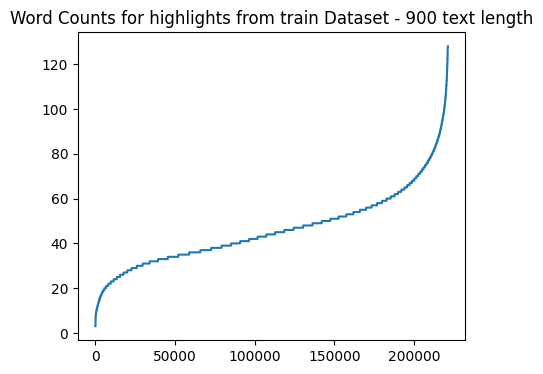

In [10]:
plot_word_length(cnn_train_sm, 'train', "900 text length")

In [4]:
cnn_train

Dataset({
    features: ['article', 'highlights'],
    num_rows: 242793
})

In [11]:
print('Train: ', len(cnn_train_sm), ", Test: ", len(cnn_test_sm), ", Validation: ", len(cnn_validation_sm))

Train:  221207 , Test:  8786 , Validation:  10273


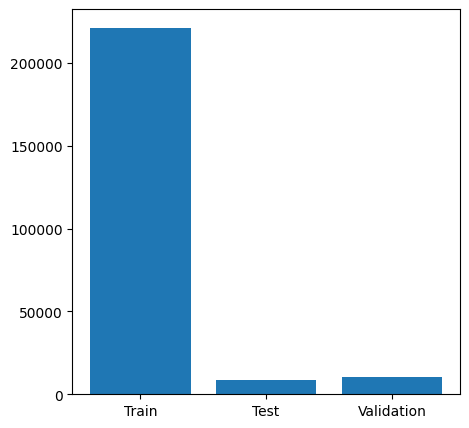

In [12]:
fig = plt.figure(figsize =(5, 5))

# Horizontal Bar Plot
plt.bar(['Train','Test','Validation'], [len(cnn_train_sm), len(cnn_test_sm), len(cnn_validation_sm)])

# Show Plot
plt.show()

In [8]:
cnn_train_sm_shuffled = cnn_train.select(np.arange(4000,150000,10))
cnn_test_sm_shuffled = cnn_test.select(np.arange(400,8000,6))
cnn_validation_sm_shuffled = cnn_validation.select(np.arange(400,9000,6))

In [8]:
print('Train: ', len(cnn_train_sm_shuffled), ", Test: ", len(cnn_test_sm_shuffled), ", Validation: ", len(cnn_validation_sm_shuffled))

NameError: ignored

15K records should be fine for small dataset experiments.

In [18]:
re.sub(r'(^\s?)', '', cnn_train_sm[1]['article'])

'washington drs removed five small polyps from president bushs colon on saturday and none appeared worrisome a white house spokesman said the polyps were removed and sent to the national naval medical center in bethesda maryland for routine microscopic examination spokesman scott stanzel said results are expected in two to three days all were small less than a centimeter half an inch in diameter he said bush is in good humor stanzel said and will resume his activities at camp david during the procedure vice president dick cheney assumed presidential power bush reclaimed presidential power at 921 a m after about two hours drs used monitored anesthesia care stanzel said so the president was asleep but not as deeply unconscious as with a true general anesthetic he spoke to first lady laura bush who is in midland texas celebrating her mothers birthday before and after the procedure stanzel said afterward the president played with his scottish terriers barney and miss beazley stanzel said h

In [ ]:
# cnn_train_sm_shuffled
# cnn_test_sm_shuffled
# cnn_validation_sm_shuffled

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# prompt: tune bartcnn model with additional masking for better accuracy
from transformers import BartTokenizer, BartForConditionalGeneration, BartConfig, DataCollatorForSeq2Seq, AutoModelForSeq2SeqLM, AutoConfig, AutoTokenizer, BartModel
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import transformers as tf

In [ ]:
cd '/content/drive/MyDrive/Colab Notebooks/ATS/BART_CNN_LARGE'

/content/drive/MyDrive/Colab Notebooks/ATS/BART_CNN_LARGE


In [36]:
!nvidia-smi

Sun Dec 10 22:28:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    39W / 300W |  16078MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [23]:
model_ckpt = "facebook/bart-base"
device = "cuda" if torch.cuda.is_available() else "cpu"
#model_ckpt = "facebook/bart-large-cnn"
#args =([bos_token='[CLS] ' , eos_token='[SEP]'])
tokenizer = BartTokenizer.from_pretrained(model_ckpt, bos_token = '[CLS]', eos_token = '[SEP]')

In [39]:
# Model architecture
model_config = BartConfig.from_pretrained(model_ckpt)
model_config.attention_dropout = 0.10
model_config.hidden_dropout = 0.10
model_config.num_attention_heads = 8
model_config.num_hidden_layers = 8
model_config.task_specific_params = {
    "summarization": {
      "early_stopping": True,
      "length_penalty": 2.0,
      "max_length": 142,
      "min_length": 56,
      "no_repeat_ngram_size": 3,
      "num_beams": 6
    }}
#model_config.vocab_size = tokenizer.vocab_size
model_bart_cnn = BartForConditionalGeneration.from_pretrained(model_ckpt).to(device)

In [40]:
model_bart_cnn.config

BartConfig {
  "_name_or_path": "facebook/bart-base",
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartModel"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classif_dropout": 0.1,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 12,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 1024,
  "model_ty

In [41]:
def convert_examples_to_features(example_batch):
    #example_batch
    input_encodings = tokenizer(example_batch['article'], max_length = 1024, truncation = True )

    target_encodings = tokenizer(example_batch['highlights'], max_length = 128, truncation = True, text_target=example_batch['highlights'])

    return   {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
     }

dataset_dailymail_pt_train = cnn_train_sm.map(convert_examples_to_features, batched = True)
dataset_dailymail_pt_test = cnn_test_sm.map(convert_examples_to_features, batched = True)
dataset_dailymail_pt_validation = cnn_validation_sm.map(convert_examples_to_features, batched = True)

Map:   0%|          | 0/221207 [00:00<?, ? examples/s]

KeyboardInterrupt: ignored

In [15]:
def generate_batch_sized_chunks(list_of_elements, batch_size):
    """split the dataset into smaller batches that we can process simultaneously
    Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

In [31]:
def calculate_metric_on_test_ds(dataset, metric, model, tokenizer,
                               batch_size=32, device=device,
                               column_text="article",
                               column_summary="highlights"):
    article_batches = list(generate_batch_sized_chunks(dataset[column_text], batch_size))
    target_batches = list(generate_batch_sized_chunks(dataset[column_summary], batch_size))
    with torch.no_grad():
        for article_batch, target_batch in tqdm(
            zip(article_batches, target_batches), total=len(article_batches)):

            inputs = tokenizer(article_batch, max_length=512,  truncation=True,
                            padding="max_length", return_tensors="pt")

            summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                            attention_mask=inputs["attention_mask"].to(device),
                            early_stopping=True,
                            length_penalty=0.8,num_beams=6, max_length=128)
           # ''' parameter for length penalty ensures that the model does not generate sequences that are too long. '''

            # Finally, we decode the generated texts,
            # replace the  token, and add the decoded texts with the references to the metric.
            decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                    clean_up_tokenization_spaces=True)
                  for s in summaries]

            decoded_summaries = [d.replace("", " ") for d in decoded_summaries]

            metric.add_batch(predictions=decoded_summaries, references=target_batch)

    #  Finally compute and return the ROUGE scores.
    score = metric.compute()
    return score

In [32]:
from transformers import TrainingArguments, Trainer

trainer_args = TrainingArguments(
    output_dir='bart-dailymail-11th-Dec', num_train_epochs=10, warmup_steps=500,
    per_device_train_batch_size=32, per_device_eval_batch_size=32, auto_find_batch_size=True,
    weight_decay=0.05, logging_steps=10,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=64, logging_dir='./logs'
)

In [33]:
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_bart_cnn)
# Optimizer
#optimizer = torch.optim.AdamW(model_bart_cnn.parameters(), lr=1e-5)

# Learning rate scheduler
#scheduler = tf.get_linear_schedule_with_warmup(optimizer, num_warmup_steps=1000, num_training_steps=10000)

In [34]:
trainer = Trainer(model=model_bart_cnn, args=trainer_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_dailymail_pt_train,
                  eval_dataset=dataset_dailymail_pt_validation)

In [35]:
trainer.train()

RuntimeError: ignored

In [27]:
# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)


In [48]:
# Model architecture
model_config = AutoConfig.from_pretrained(model_ckpt)
model_config.attention_dropout = 0.1
model_config.hidden_dropout = 0.1
model_config.num_attention_heads = 8
model_config.num_hidden_layers = 8
model_config.vocab_size = tokenizer.vocab_size
model_bart_cnn = BartForConditionalGeneration.from_pretrained(model_ckpt, config=model_config, ignore_mismatched_sizes=True).to(device)


Some weights of BartForConditionalGeneration were not initialized from the model checkpoint at facebook/bart-large-cnn and are newly initialized because the shapes did not match:
- model.decoder.embed_tokens.weight: found shape torch.Size([50264, 1024]) in the checkpoint and torch.Size([50265, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
# Data collator
data_collator = DataCollatorForSeq2Seq(tokenizer, model_bart_cnn)

# Create the dataloaders
train_dataloader = DataLoader(cnn_train, batch_size=16, shuffle=True, collate_fn=data_collator)
test_dataloader = DataLoader(cnn_test, batch_size=16, shuffle=False, collate_fn=data_collator)
val_dataloader = DataLoader(cnn_validation, batch_size=16, shuffle=False, collate_fn=data_collator)


In [65]:
input_batch, output_batch = cnn_train.map(convert_examples_to_features, batched = True)

Map:   0%|          | 0/239272 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3856: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


TypeError: ignored

In [49]:
# Optimizer
optimizer = torch.optim.AdamW(model_bart_cnn.parameters(), lr=1e-5)

# Learning rate scheduler
scheduler = tf.get_linear_schedule_with_warmup(optimizer, num_warmup_steps=1000, num_training_steps=10000)

# Training loop
for epoch in range(10):
    # Train
    model_bart_cnn.train()
    train_loss = 0
    for batch in tqdm(dataset_dailymail_pt_train):
        #batch = batch.to(device)
        outputs = model_bart_cnn(**batch)
        loss = outputs.loss
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation
    with torch.no_grad():
        model_bart_cnn.eval()
        val_loss = 0
        for batch in tqdm(dataset_dailymail_pt_validation):
            batch = batch.to(device)
            outputs = model_bart_cnn(**batch)
            loss = outputs.loss
            val_loss += loss.item()

    # Logging
    print(f"Epoch {epoch+1}: Train loss = {train_loss/len(cnn_train):.4f}, Val loss = {val_loss/len(cnn_validation):.4f}")

# Save the model
model_bart_cnn.save_pretrained("my_bart_cnn_model_full")


  0%|          | 0/239272 [00:00<?, ?it/s]


TypeError: ignored

In [52]:
input_ids = tokenizer("This is the input text.", return_tensors="pt").input_ids

attention_mask = tokenizer("This is the input text.", return_tensors="pt").attention_mask

token_type_ids = tokenizer("This is the input text.", return_tensors="pt")

position_ids = tokenizer("This is the input text.", return_tensors="pt")

head_mask = torch.zeros((1, 16, 64), dtype=torch.float)

In [57]:
token_type_ids

{'input_ids': tensor([[   0,  713,   16,    5, 8135, 2788,    4,    2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}

In [20]:
pipe = pipeline('summarization', model = model_ckpt )

pipe_out = pipe(cnn_train_sm_shuffled[0]['article'] )

print(pipe_out)

[{'summary_text': 'Hundreds of refugees blocked a main road in northwest pakistan to protest living conditions for some of the 1 5 million pakistaniis forced to flee their homes in the past three weeks. U n says the government has been making big promises but none of those were ever fulfilled. The scale and speed of the displacement said to be the worst since the rwandan genocide in 1994 have overwhelmed aid workers.'}]


In [21]:
original_summary = cnn_train_sm_shuffled[0]['highlights']
generated_summary = pipe_out[0]['summary_text']

In [25]:
# Calculate ROUGE scores
rouge_scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL', 'rougeLsum'])
original_summary = re.sub(r'[\t\n\r\f\v]', ' ', original_summary)
#summary.replace('<n>', '')
#generated_summary = re.sub(r'<n>', ' ', generated_summary)
rouge_scores = rouge_scorer.score(generated_summary, original_summary)

# Print ROUGE scores line by line
for metric, scores in rouge_scores.items():
    print(f"{metric}:")
    print(f"Precision: {scores.precision}")
    print(f"Recall: {scores.recall}")
    print(f"F1 Score: {scores.fmeasure}")
    print()

rouge1:
Precision: 0.34210526315789475
Recall: 0.18309859154929578
F1 Score: 0.23853211009174313

rouge2:
Precision: 0.10810810810810811
Recall: 0.05714285714285714
F1 Score: 0.07476635514018691

rougeL:
Precision: 0.23684210526315788
Recall: 0.1267605633802817
F1 Score: 0.16513761467889906

rougeLsum:
Precision: 0.23684210526315788
Recall: 0.1267605633802817
F1 Score: 0.16513761467889906



### Evaluating the BART model on CNN data

In [ ]:
# Summarize and evaluate a single article from the test dataset
article = cnn_train_sm_shuffled['article'][0]
summary = cnn_train_sm_shuffled['highlights'][0]
original_summary = summary
generated_summary = generate_summary(article)
rouge_scores = calculate_rouge_scores(original_summary, generated_summary)

print("Original Summary:")
print(original_summary)
print("\nGenerated Summary:")
print(generated_summary)

In [36]:
rouge_metric = load_metric('rouge')

In [17]:
# Function to generate summaries
def generate_summary(article_text):
    inputs = tokenizer.encode("summarize: " + article_text, return_tensors="pt", max_length=512, truncation=True)
    summary_ids = model_bart_cnn.generate(inputs, max_length=120, min_length=30, length_penalty=2.0, num_beams=6, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Function to calculate ROUGE scores
def calculate_rouge_scores(original_summary, generated_summary):
    rouge = load_metric("rouge")
    scores = rouge.compute(predictions=[generated_summary], references=[original_summary])
    return scores

In [ ]:


score = calculate_metric_on_test_ds(cnn_test_sm_shuffled, rouge_metric, model_bart_cnn, tokenizer, column_text = 'article', column_summary='highlights', batch_size=8)

In [48]:
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = ['BART_CNN_LARGE'])

,rouge1,rouge2,rougeL,rougeLsum
BART_CNN_LARGE,0.009043,0.000544,0.008985,0.008975


In [ ]:
cnn_sm_train_df['article'][0]

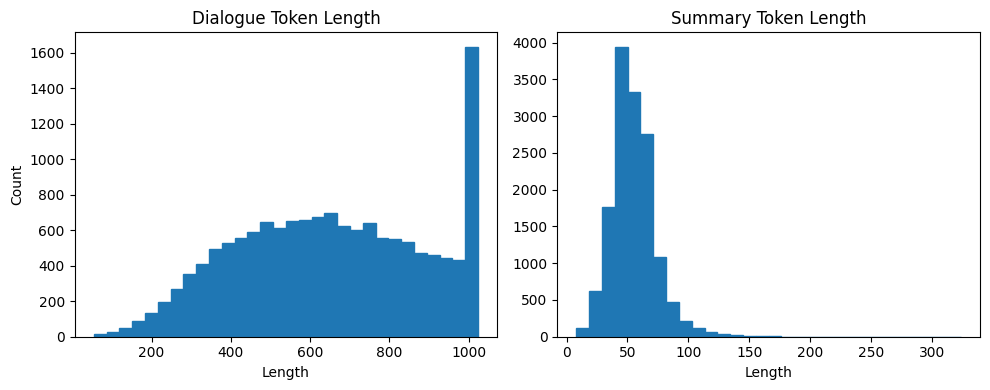

In [26]:
dialogue_token_len = [len(tokenizer.encode(s, truncation=True)) for s in cnn_train_sm_shuffled['article']]

summary_token_len = [len(tokenizer.encode(s, truncation=True)) for s in cnn_train_sm_shuffled['highlights']]


fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(dialogue_token_len, bins = 30, color = 'C0', edgecolor = 'C0' )
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(summary_token_len, bins = 30, color = 'C0', edgecolor = 'C0' )
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [32]:
trainer.train()

You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss
500,1.684800,1.748196


TrainOutput(global_step=608, training_loss=1.7324550120454085, metrics={'train_runtime': 1702.9861, 'train_samples_per_second': 8.573, 'train_steps_per_second': 0.357, 'total_flos': 2.4665442805088256e+16, 'train_loss': 1.7324550120454085, 'epoch': 1.0})

In [39]:
trainer.save_model('bart-sm_cnn_dailymail-9th-Dec')

In [42]:
my_model = BartForConditionalGeneration.from_pretrained('bart-sm_cnn_dailymail-9th-Dec')

In [50]:
score = calculate_metric_on_test_ds(
    cnn_test_sm_shuffled, rouge_metric, trainer.model, tokenizer, batch_size=4, column_text = 'article', column_summary= 'highlights'
)

rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = [f'bart'] )

100%|██████████| 317/317 [12:24<00:00,  2.35s/it]


,rouge1,rouge2,rougeL,rougeLsum
bart,0.009086,0.000661,0.008999,0.009016


In [38]:
import gc
torch.cuda.empty_cache()
gc.collect()

0